# Машинное обучение, ФКН ВШЭ

# Семинар 9

## Сравнение бустинга и бэггинга

Обсудим, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга каждый базовый алгоритм настраивается на одно и тоже распределение данных (но
на разные выборки из него). Какие-то из алгоритмов могут переобучиться на 
своей выборке данных, и их обобщающая способность от этого снизится. Усреднение
же алгоритмов позволяет ослабить это переобучение, так как уменьшает влияние
каждого алгоритма (и каждой выборки), при этом сохраняя настройку на общее
распределение данных. Если мы обучим большое количество базовых алгоритмов,
то последующие добавления новых алгоритмов уже не позволят улучшить качество
модели, так как они будут настраиваться на то же распределение, но по этой же
причиние не возникнет и переобучение.

В случае же бустинга все алгоритмы настраиваются на разные распределения - каждый
новый на ошибки всех предыдущих. Это позволяет на каждом шаге настраиваться на
исходное распределение все точнее и точнее. С другой стороны, это может быть
и источником переобучения, так как мы обучаемся на конкретной конечной выборке данных,
а не на всем распределении. Если мы обучим большое количество базовых алгоритмов,
то последующие добавления новых алгоритмов будут продолжать настраиваться на текущие
данные, и могут уменьшать ошибку на обучающей выборке, но увеличивать ее на тестовой,
то есть увеличивать переобучение.

### Модельный пример

Продемонстрируем это сравнение на простом модельном примере.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Сгенерируем простой датасет

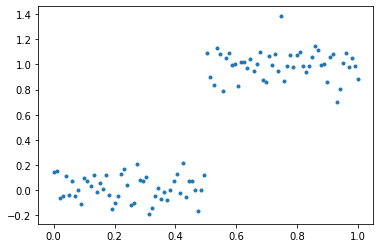

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.plot(X_train, Y_train, '.')

Обучим на нем большое количество решающих деревьев бэггингом. Для наглядности на графиках используем неравномерный шаг по количеству деревьев.

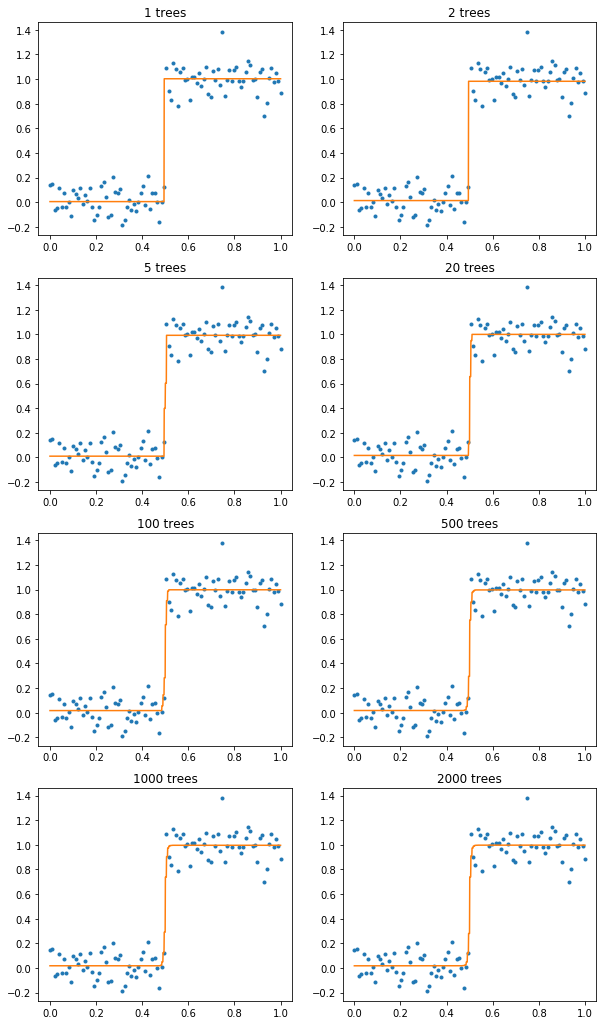

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1), warm_start=True)
plt.figure(figsize=(10, 18))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.plot(X_train, Y_train, '.')
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)))
    plt.title('{} trees'.format(s))

Видим, что с какого-то момента итоговая функция перестает меняться.

Теперь проделаем то же самое для градинентного бустинга.

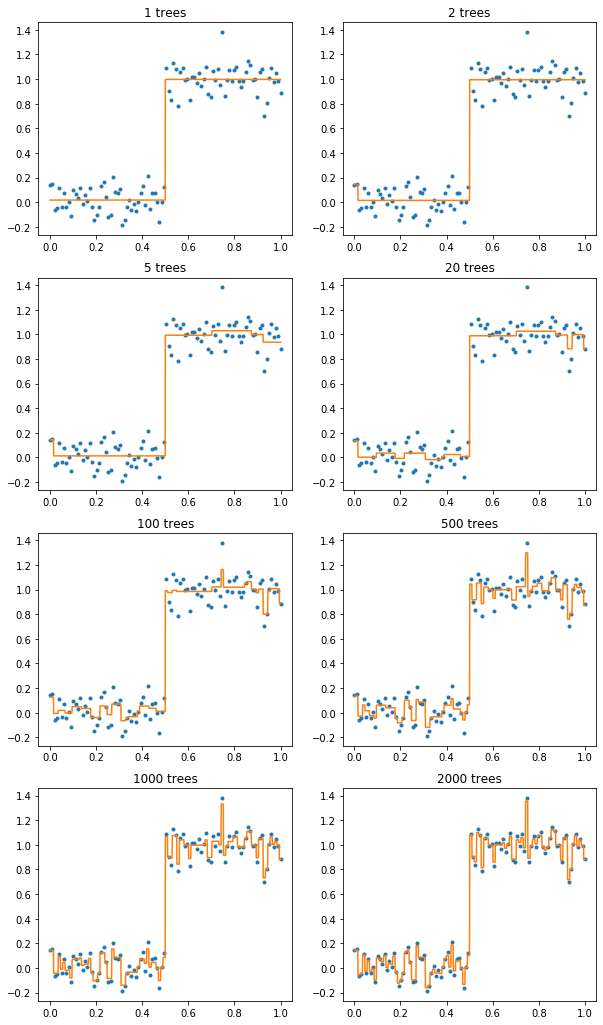

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(10, 18))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.plot(X_train, Y_train, '.')
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)))
    plt.title('{} trees'.format(s))

Видно, что бустинг быстро настроился на исходное распределение, и далее начал настраиваться уже на
конкретные данные, из-за чего сильно переобучился.


Бороться с этой проблемой бустинга можно с помощью выбора очень простого базового алгоритма, или
же искусственным снижением веса новых алгоритмов умножение их на некоторое число $\alpha < 1 $. Это
замедляет обучение по сравнению с бэггингом, но зато позволяет ослабить переобучение, и
в итоге получить более качественный алгоритм. Правда, обучение сколь угодно большого
количества базовых алгоритмов все равно может привести к переобучению. Ниже приведена демонстрация
на тех же данных.

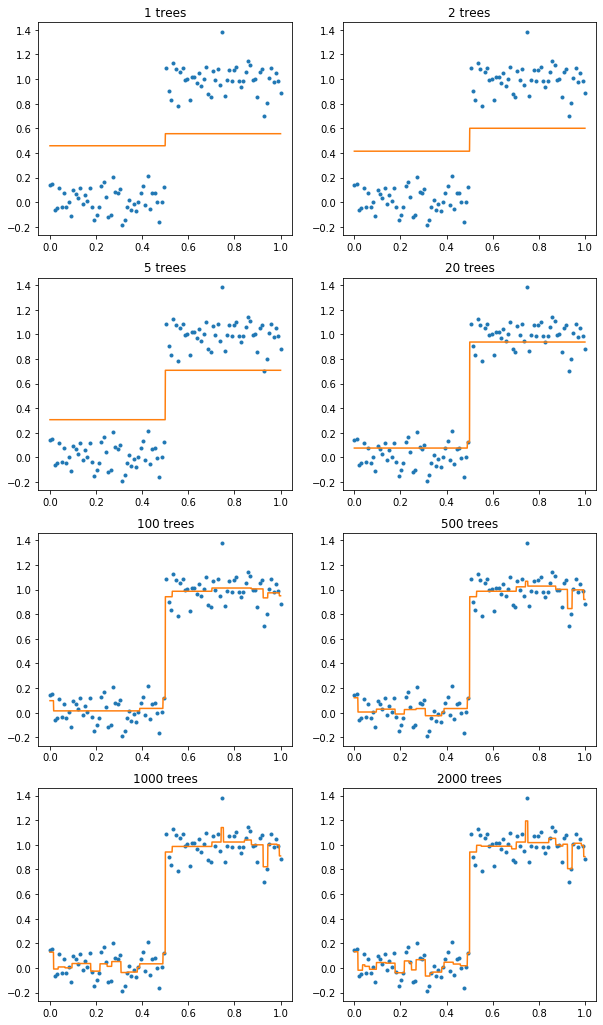

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(10, 18))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.plot(X_train, Y_train, '.')
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)))
    plt.title('{} trees'.format(s))

### Реальный пример

Теперь проверим описанный выше эффект на реальных данных.

In [6]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split


ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')